In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import urllib
import json
from time import sleep

## K-均值聚类

K-均值算法伪代码：  
创建k个点作为起始质心（通常随机选择）  
当任意一个点的簇分配结果发生改变时：  
&ensp;&ensp;&ensp;&ensp;对数据集中的每个数据点：  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;对每个质心：   
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;计算质心与数据点之间的距离  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;将数据点分配到距其最近的簇  
&ensp;&ensp;&ensp;&ensp;对每一个簇，计算簇中所有点的均值并将均值作为质心

## 支持函数

In [2]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        # 将每行读成浮点数
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    return dataMat

### 计算两个向量的欧式距离

In [3]:
def distEclud(vecA, vecB):
    return np.sqrt(np.sum(np.power(vecA - vecB, 2)))

### 为给定数据集构建包含k个随即质心的集合

In [4]:
def randCent(dataSet, k):
    n = np.shape(dataSet)[1]
    centroids = np.mat(np.zeros((k, n)))
    for j in range(n):
        minJ = min(dataSet[:, j])
        rangeJ = float(max(dataSet[:, j]) - minJ)
        centroids[:, j] = minJ + rangeJ * np.random.rand(k, 1)
    return centroids

## k-均值聚类算法

In [5]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m, 2)))    # 一列记索引，一列记当前点到质心的距离
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = np.inf
            minIndex = -1
            # 寻找最近的质心
            for j in range(k):
                distJI = distMeas(centroids[j, :], dataSet[i, :])
                if distJI < minDist:
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i, 0] != minIndex:    # 任一点簇发生改变，则改变标志
                clusterChanged = True
            clusterAssment[i, :] = minIndex, minDist ** 2
        print(centroids)
        # 更新质心位置
        for cent in range(k):
            ptsInClust = dataSet[np.nonzero(clusterAssment[:, 0].A == cent)[0]]
            centroids[cent, :] = np.mean(ptsInClust, axis = 0)
    return centroids, clusterAssment

## 二分K-均值算法  
二分K-均值算法伪代码：  
将所有点看成一个簇  
当簇数目小于k时：  
&ensp;&ensp;&ensp;&ensp;对于每一个簇：  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;计算总误差   
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;在给定的簇上面进行K-均值聚类（k=2）  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;计算将该簇一分为二之后的总误差  
&ensp;&ensp;&ensp;&ensp;选择使得误差最小的那个簇进行划分操作

In [6]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m, 2)))
    # 创建一个初试簇
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]
    centList = [centroid0]
    for j in range(m):
        clusterAssment[j, 1] = distMeas(np.mat(centroid0), dataSet[j, :]) ** 2
    while len(centList) < k:
        lowestSSE = np.inf
        for i in range(len(centList)):
            # 尝试划分每一簇
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:, 0].A == i)[0], :]
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:, 1])
            sseNotSplit = sum(clusterAssment[np.nonzero(clusterAssment[:, 0].A != i)[0], 1])
            print('sseSplit, and notSplit:', sseSplit, sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        # 更新簇的分配结果
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 1)[0], 0] = len(centList)
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 0)[0], 0] = bestCentToSplit
        print('the bestCentToSplit is:', bestCentToSplit)
        print('the len of bestClustAss is:',len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0, :].tolist()[0]
        centList.append(bestNewCents[1, :].tolist()[0])
        clusterAssment[np.nonzero(clusterAssment[:, 0].A == bestCentToSplit)[0], :] = bestClustAss
    return np.mat(centList), clusterAssment

## 对地图上的点进行聚类

### 雅虎地址转换经纬度

从yahoo返回字典

In [7]:
def geoGrab(stAddress, city):
    apiStem = 'http://where.yahooapis.com/geocode?'
    params = {}
    params['flags'] = 'J'    # 返回类型设为JSON
    params['appid'] = 'aaa0VN6k'
    params['location'] = '%s %s' % (stAddress, city)
    url_params = urllib.parse.urlencode(params)    # 将字典转化为可用IRL传递的字符串格式
    yahooApi = apiStem + url_params
    print(yahooApi)    # 打印输出的URL
    c = urllib.request.urlopen(yahooApi)    # 解码
    return json.loads(c.read())   

将字典封装并保存到文件中

In [8]:
def massPlaceFind(fileName):
    fw = open('place.txt', 'w')
    for line in open(fileName).readlines():
        line = line.strip()
        lineArr = line.split('\t')
        retDict = geoGrab(lineArr[1], lineArr[2])
        if retDict['ResultSet']['Error'] == 0:
            lat = float(retDict['ResultSet']['Results'][0]['latitude'])
            lng = float(retDict['ResultSet']['Results'][0]['longitude'])
            print('%s\t%f\t%f\n' % (line, lat, lng))
        else:
            print('error fetching')
        sleep(1)
    fw.close()

### 球面距离计算  
返回地球表面两点之间的距离

In [9]:
def distSLC(vecA, vecB):
    a = np.sin(vecA[0, 1] * np.pi / 180) * np.sin(vecB[0, 1] * np.pi / 180)
    b = np.cos(vecA[0, 1] * np.pi / 180) * np.cos(vecB[0, 1] * np.pi / 180) * np.cos((vecB[0, 0] - vecA[0,0]) * np.pi / 180)
    return np.arccos(a + b) * 6371.0

### 簇绘图

In [10]:
def clusterClubs(numClust=5):
    datList = []
    for line in open('place.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = np.mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    
    fig = plt.figure()
    rect = [0.1,0.1,0.8,0.8]
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']
    axprops = dict(xticks = [], yticks = [])
    ax0 = fig.add_axes(rect, label = 'ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1 = fig.add_axes(rect, label = 'ax1', frameon = False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[np.nonzero(clustAssing[:,0].A == i)[0], :]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:, 0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker = markerStyle, s = 90)
    ax1.scatter(myCentroids[:, 0].flatten().A[0], myCentroids[:, 1].flatten().A[0], marker = '+', s = 300)
    plt.show()

[[-122.80397949   45.50909032]
 [-122.80519018   45.61376165]]
[[-122.62470355   45.50122043]
 [-122.67816056   45.58621511]]
[[-122.62033676   45.50037943]
 [-122.691466     45.57519591]]
[[-122.60319805   45.503961  ]
 [-122.74355464   45.54509336]]
[[-122.5919301    45.50705212]
 [-122.73627121   45.52613453]]
[[-122.5783403    45.50954025]
 [-122.7255474    45.51717564]]
[[-122.56818551   45.5102949 ]
 [-122.7142141    45.51492203]]
[[-122.56409551   45.51016235]
 [-122.70981637   45.51478609]]
sseSplit, and notSplit: [[3073.83037153]] 0
the bestCentToSplit is: 0
the len of bestClustAss is: 69
[[-122.58643817   45.45026219]
 [-122.42526442   45.53360665]]
[[-122.58411921   45.50985455]
 [-122.49150962   45.51127813]]
[[-122.59256115   45.51345069]
 [-122.49681309   45.50238991]]
[[-122.59706504   45.51390729]
 [-122.50322869   45.50324862]]
[[-122.59880678   45.51552409]
 [-122.50706986   45.50135379]]
sseSplit, and notSplit: [[922.26693035]] [[1685.03052598]]
[[-122.68335651   45.

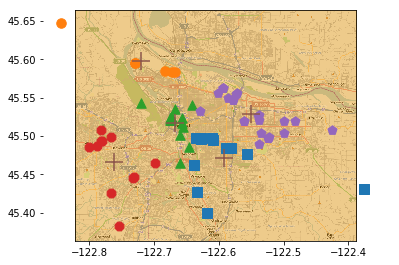

In [11]:
clusterClubs()